 <a id='00_top'>  </a>

# Textract Post-Processing

This is the workflow for Automatic document content extraction using Amazon Textract
<br> It includes two parts:
<br> <b> Part 1, First time run: Define TemplateJSON and Correction Functions  </b>  
<br> <b> Part 2, Repeat run: automatically extract desired content of same type PDFs </b> 



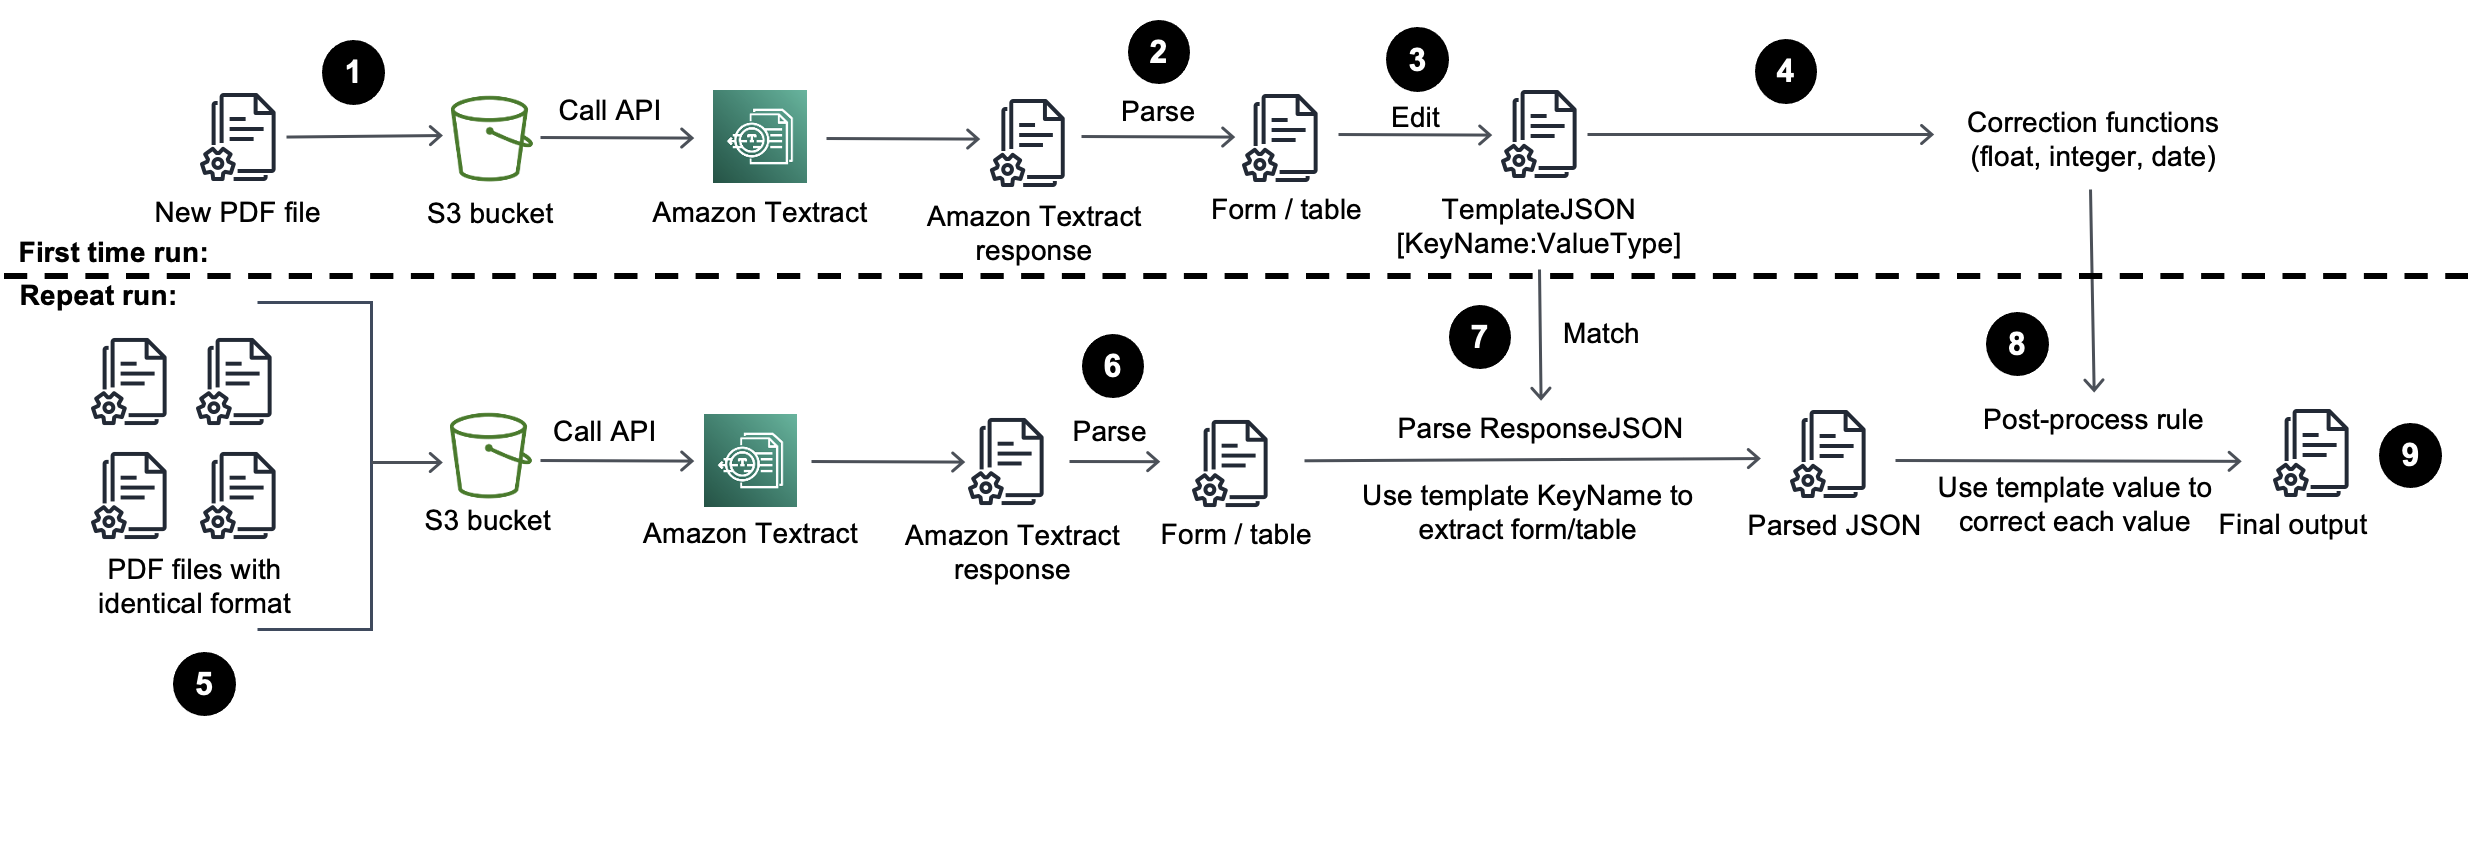

## Table of Content 
* [Install & Import packages](#Install_packages)

* [Function Define](#Function_define) 
 * [Parse raw Textract Response JSON to extract Forms](#parse_raw_extract_form)
 * [Parse raw Textract Response JSON to extract tables](#parse_raw_extract_table)
 * [Match parsed JSON with TemplateJSON](#match_templateJSON)
 * [Post Processing](#post_processing)


* [Part 1: First time run](#part1)
 * [1. Document preparation](#11_Document_prep)
 * [2. Call Textract API, Parse Textract Response JSON](#12_parseJSON)
   * [Document specific processing: Group Check-box](#131_checkbox)
 * [3. Edit TemplateJSON](#14_edittemplate)
 * [4. Post-processing correction](#16_postprocessing_correction) 


* [Part 2: Repeat run](#part2)
 *  [5. Document preparation](#21_document_prep)
 *  [6. Call Textract API, Parse Textract Response JSON](#22_parseJSON)
   * [Document specific processing: Group Check-box](#231_checkbox)
 *  [7. Match parsed JSON with TemplateJSON](#23_matchtemplate)
 * [8. Post-processing correction](#24_postprocessing_correction)
 * [9. Final output](#24_postprocessing_correction)


<a id='Install_packages'>  </a>
# Install & Import packages

[Go to top](#00_top)

In [118]:
import pandas as pd
key = pd.read_csv('../../../chehalis_accessKeys.csv')
import boto3

ACCESS_KEY = key['Access key ID'][0]
SECRET_KEY = key['Secret access key'][0]
s3 = boto3.client('s3',region_name='us-west-2',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY)
    #aws_session_token=SESSION_TOKEN
#)

In [20]:
try:
    from PyPDF2 import PdfFileWriter, PdfFileReader
except:
    !pip3 install PyPDF2
    from PyPDF2 import PdfFileWriter, PdfFileReader
    
try:
    from pdf2image import convert_from_path
except:
    !pip3 install pdf2image
    from pdf2image import convert_from_path
    
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)

try:
    from pdf2jpg import pdf2jpg
except:
    !pip3 install pdf2jpg
    from pdf2jpg import pdf2jpg

In [21]:
import pandas as pd
import numpy as np
import json
import boto3
import difflib
from io import BytesIO
import os

%matplotlib inline

<a id='Function_define'>  </a>
# Functions Define:

[Go to top](#00_top)

<a id='parse_raw_extract_form'>  </a>
## Functions: Parse raw Textract Response JSON to extract Forms [Key-Value pair]

In [22]:
def find_value_block(key_block, value_map):
    for relationship in key_block['Relationships']:
        if relationship['Type'] == 'VALUE':
            for value_id in relationship['Ids']:
                value_block = value_map[value_id]
    return value_block

def get_text(result, blocks_map):
    text = ''
    if 'Relationships' in result:
        for relationship in result['Relationships']:
            if relationship['Type'] == 'CHILD':
                for child_id in relationship['Ids']:
                    word = blocks_map[child_id]
                    if word['BlockType'] == 'WORD':
                        text += word['Text'] + ' '
                    if word['BlockType'] == 'SELECTION_ELEMENT':
                        if word['SelectionStatus'] == 'SELECTED':
                            text += 'X '    
                                
    return text

def form_kv_from_JSON(response):
    blocks=response['Blocks']
    key_map = {}
    value_map = {}
    block_map = {}
    for block in blocks:
        block_id = block['Id']
        block_map[block_id] = block
        if block['BlockType'] == "KEY_VALUE_SET":
            if 'KEY' in block['EntityTypes']:
                key_map[block_id] = block
            else:
                value_map[block_id] = block
    kvs = {}

    for block_id, key_block in key_map.items():
        value_block = find_value_block(key_block, value_map)
        key = get_text(key_block, block_map)
        val = get_text(value_block, block_map)

        kvs[key] = val
    return kvs


In [23]:
def find_word_boundingbox(findword,response):
#given Textract reponse and phrase (has to be in one single line)
#return the bound box of the word/phrase 
    word_find={}

    for item in response["Blocks"]:
        if item["BlockType"] == "LINE":
                    thisTop=item['Geometry']['BoundingBox']['Top']
                    thisLeft=item['Geometry']['BoundingBox']['Left']
                    thisHeight=item['Geometry']['BoundingBox']['Height']
                    thisWidth=item['Geometry']['BoundingBox']['Width']
                    if findword in item["Text"]:
                        #print(item['Geometry']['BoundingBox'])
                        word_find[findword]={}
                        word_find[findword]['Top']=item['Geometry']['BoundingBox']['Top']
                        word_find[findword]['Height']=item['Geometry']['BoundingBox']['Height']
                        word_find[findword]['Left']=item['Geometry']['BoundingBox']['Left']
                        word_find[findword]['Width']=item['Geometry']['BoundingBox']['Width']
    return word_find
                    

In [24]:
def find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02) :
# given Textract Response, and [Top,Left,word_height,right] - bounding box need to search for
# find Key:value pairs within the bounding box of no_line_above+no_line_below  (no_line_below including current line)
# margin is small value add/substract from each value to take into account small margin beyound bounding box

    #get key_map,value_map,block_map from response (textract JSON)
    blocks=response['Blocks']
    key_map = {}
    value_map = {}
    block_map = {}
    for block in blocks:
        block_id = block['Id']
        block_map[block_id] = block
        if block['BlockType'] == "KEY_VALUE_SET":
            if 'KEY' in block['EntityTypes']:
                key_map[block_id] = block
            else:
                value_map[block_id] = block
                
    ## find key-value pair within given bounding box:            
    kv_pair={}
    for block_id, key_block in key_map.items():
        value_block = find_value_block(key_block, value_map)
        key = get_text(key_block, block_map)
        val = get_text(value_block, block_map)
        if (value_block['Geometry']['BoundingBox']['Top']>=top-no_line_above*word_height-margin*top and   
                    value_block['Geometry']['BoundingBox']['Top']<=top+no_line_below*word_height+margin*word_height and
                    value_block['Geometry']['BoundingBox']['Left']>=left-margin*left and
                    value_block['Geometry']['BoundingBox']['Left']+value_block['Geometry']['BoundingBox']['Width']<=right+margin*right
                   ) :
            kv_pair[key]=val
    return kv_pair


<a id='parse_raw_extract_table'>  </a>
## Functions: Parse raw Textract Response JSON to extract tables

[Go to top](#00_top)

In [25]:
def get_rows_columns_map(table_result, blocks_map):
    rows = {}
    for relationship in table_result['Relationships']:
        if relationship['Type'] == 'CHILD':
            for child_id in relationship['Ids']:
                cell = blocks_map[child_id]
                if cell['BlockType'] == 'CELL':
                    row_index = cell['RowIndex']
                    col_index = cell['ColumnIndex']
                    if row_index not in rows:
                        rows[row_index] = {}
                    rows[row_index][col_index] = get_text(cell, blocks_map)
    return rows

def get_tables_fromJSON(response):    
    blocks=response['Blocks']
    blocks_map = {}
    table_blocks = []
    for block in blocks:
        blocks_map[block['Id']] = block
        if block['BlockType'] == "TABLE":
            table_blocks.append(block)

    if len(table_blocks) <= 0:
        print("<b> NO Table FOUND </b>")
    
    AllTables=[]
    for table_result in table_blocks:
        tableMatrix=[]
        rows=get_rows_columns_map(table_result, blocks_map)
        for row_index, cols in rows.items():
            thisRow=[]
            for col_index, text in cols.items():
                thisRow.append(text)
            tableMatrix.append(thisRow)
        AllTables.append(tableMatrix)
    return AllTables

def topNlongestCellinTable(thisTable,N):
    # give a nested list represent a table, return longest N cells of string in the table 
    listCell=[item for row in thisTable for item in row] #flatten the nested list into unnested list
    listCell.sort(key = lambda s: len(s),reverse=True) # sort based on string length
    topNlongest=listCell[:N]
    return topNlongest

def tableHeader2JSON(thisTable):
    #input: nested list represent one 2D table     
    row0=thisTable[0]
    col0=[row[0] for row in thisTable]
    tableUniqueStrings=topNlongestCellinTable(thisTable,3)
    tableName=tableUniqueStrings[0] #give 1 rowName as tableName 
    tableJson={"TableName":tableName,"TableUniqueStrings":tableUniqueStrings,"ColumnNames":row0,"RowNames:":col0}
    return tableJson

def TableRemoveEmptyRow(thisTable):
    thisTableNew=[]
    for row in thisTable:
        nCell=len(row)
        nEmpty=0
        for cell in row:
            if cell == "":
                nEmpty+=1
        if nCell ==nEmpty: 
            continue
        thisTableNew.append(row)
    return thisTableNew

<a id='match_templateJSON'>  </a>
## Functions: Match parsed JSON with TemplateJSON

[Go to top](#00_top)

In [26]:
#### function: correct parsed JSON output Key-Value's key using predefined Key
## input: form_kv - JSON output parsed  Key-Value pair dict
##        form_kv_standard - form predefined template with correct Key/value(format) 
## function compare each parsed JSON's Key with predefined template Key, and use the close-matched template key

def form_kv_correction(form_kv,form_kv_standard):
    extractedKeys=form_kv.keys()
    templateKeys=form_kv_standard.keys()
    templateKeys_kv=[key for key in templateKeys if key[:5]!="Table" ]
    form_kv_corrected={}
    for key in templateKeys_kv:
        this_correctkey_matchlist=difflib.get_close_matches(key,extractedKeys, n = 1,cutoff = 0.5)
        if len(this_correctkey_matchlist)>0:
            this_key_correct=this_correctkey_matchlist[0]
            form_kv_corrected[key]=form_kv[this_key_correct]
        else:
            form_kv_corrected[key]="NO_EXTRACTED_VALUE_KEY"        
    return form_kv_corrected

def topNlongestCellinTable(thisTable,N):
    # give a nested list represent a table, return longest N cells of string in the table 
    listCell=[item for row in thisTable for item in row] #flatten the nested list into unnested list
    listCell.sort(key = lambda s: len(s),reverse=True) # sort based on string length
    topNlongest=listCell[:N]
    return topNlongest

def FindMatchedTable_longestString(thisTableNlongest,form_kv_standard,N):
    # given one table's longest String
    tbl_uniquestr={}
    templateKeys=form_kv_standard.keys()
    templateKeys_table=[key for key in templateKeys if key[:5]=="Table" ]
    for tbl in templateKeys_table:
        try: tbl_uniquestr[tbl]=form_kv_standard[tbl]['TableUniqueStrings']
        except: tbl_uniquestr[tbl]=''
    
    TblMatchNString={}
    for tbl in tbl_uniquestr.keys():
        matchN=0
        thistblUniqueStringList=tbl_uniquestr[tbl]
        for thisCell in thisTableNlongest:
            matchedString=difflib.get_close_matches(thisCell,thistblUniqueStringList, n = 1,cutoff = 0.6)
            if len(matchedString)>0:
                matchN=matchN+1
        TblMatchNString[tbl]=matchN
    findMatchedtable=[k for k,v in TblMatchNString.items() if v >= N-1]
    if len(findMatchedtable)>0:
        return findMatchedtable[0]
    else: 
        return "NO_MATCHED_TABLE"

def FindMatchedTable_colNames(col_name_extracted,form_kv_standard):
    #given one table's column names
    tbl_col_name={}
    templateKeys=form_kv_standard.keys()
    templateKeys_table=[key for key in templateKeys if key[:5]=="Table" ]
    for tbl in templateKeys_table:
        tbl_col_name[tbl]=form_kv_standard[tbl]['ColumnNames']
        if col_name_extracted == tbl_col_name[tbl]:
            return tbl
    return "NO_MATCHED_TABLE"
        
    
def form_Table_correction(form_tables,form_kv_standard,N):
### function: correct parsed JSON output Table using predefined form_kv_table template
## input: form_table - JSON output parsed Table [nested list represent table]
##        form_kv_standard - form predefined template with correct Table hearder(column/row names)
## function compare each parsed JSON's table with predefined table header, and use the close-matched template Table header
    form_tables_corrected={}
    templateKeys=form_kv_standard.keys()
    templateKeys_table=[key for key in templateKeys if key[:5]=="Table" ]
    
    for template_table in templateKeys_table:
        form_tables_corrected[template_table]={}
        for thisExtractTable in form_tables:
            
            #loacte the table from extracted tables that match template: 
            #method 1: use top N longest Cell string
            thisExtractTableTopN=topNlongestCellinTable(thisExtractTable,N)
            matchedTableName=FindMatchedTable_longestString(thisExtractTableTopN,form_kv_standard,N)
            
            #method 2: use Column name
            col_name_extracted=thisExtractTable[0]
            matchedTableName=FindMatchedTable_colNames(col_name_extracted,form_kv_standard)
            
            if matchedTableName != 'NO_MATCHED_TABLE':
                form_tables_corrected[matchedTableName]=thisExtractTable
            
    return form_tables_corrected

### function: given a corrected parsed table(with correct Column/Row names), and rowName, colName, 
# return the specific cell value at [rowName,colName]
def find_row_col_intable(table,rowName,colName):
    # give table and rowName, colName, return cell value 
    # rowName/colName can be number index (start from 1, including header Column/Row)    
    row0_lower=[x.lower() for x in table[0]]    
    if not isinstance(colName, int): 
        iCol=row0_lower.index(colName.lower())
    else: 
        iCol=colName-1    
    if not isinstance(rowName, int):
        for row in table:
            if rowName.lower() in row[0].lower():
                return row[iCol]
    else:
        return table[rowName-1][iCol]
        
def form_Table_extractCell(form_table_corrected,form_kv_standard):
# input form_table_corrected JSON with table and table value (outout of function: form_Table_correction)
# form_kv_standard: predefined tempalte dict with table required extract cell
# function extract required cell specificed in form_kv_standard template 
    form_tables_extractCellValue={}
    templateKeys=form_kv_standard.keys()
    templateKeys_table=[key for key in templateKeys if key[:5]=="Table" ]
    correctKeys_table=form_table_corrected.keys()
    for template_table in templateKeys_table:
        form_tables_extractCellValue[template_table]={}
        thisTableValue=form_table_corrected[template_table]
        for cellRowCol in form_kv_standard[template_table]['ExtractCell']:
            thisRow=cellRowCol['Row']
            thisCol=cellRowCol['Column']
            thisCellName=cellRowCol['customKey']
            thisCellValue=find_row_col_intable(thisTableValue,thisRow,thisCol)
            
            ###################################################
            # if maintain template format {"Row":xx,"Column":xx} 
            # uncomment above:form_tables_extractCellValue[template_table]["ExtractCell"]=[]
#            thisCell={}
#            thisCell["Row"]=thisRow
#            thisCell["Column"]=thisCol
#            thisCell[thisCellName]=thisCellValue
#            form_tables_extractCellValue[template_table]["ExtractCell"].append(thisCell)
            #####################################################
            
            #####################################################
            # only return extract value 
            form_tables_extractCellValue[template_table][thisCellName]=thisCellValue
            #####################################################            
    return  form_tables_extractCellValue

<a id='post_processing'>  </a>
## Functions: Post-Processing

[Go to top](#00_top)

#### Main function call for post-processing

In [27]:
## Function: Rule based post-processing correction:
# Input: ParsedJSON, templateJSON
# output: finalJSON with corrected value 

def postprocessingCorrection(parsedJSON, templateJSON):
    finalJSON={}
    
    for thisKey in parsedJSON.keys():
        #only correct Key-Value pair 
        if thisKey[:5] != 'Table':
            thisValue=parsedJSON[thisKey]
            thisValue_DataType=templateJSON[thisKey]

            if "string" in thisValue_DataType.lower():
                thisValue_correct=ppStringCorrection(thisValue,thisValue_DataType)

            if "float" in thisValue_DataType.lower():
                thisValue_correct=ppFloatCorrection(thisValue,thisValue_DataType)

            if "int" in thisValue_DataType.lower():
                thisValue_correct=ppIntCorrection(thisValue,thisValue_DataType)

            finalJSON[thisKey]=thisValue_correct
        #not correct for entire table (can be done on cell level)
        else:
            finalJSON[thisKey]=parsedJSON[thisKey]
    return finalJSON

#### Functions for each dataType correction:


In [28]:
###### Function: StringCorrection ###############
def ppStringCorrection(inputS,DataType):
    
    if DataType.lower() is "String_Number".lower():
        correctS=pp_ReplaceOwith0(inputS)        
        return correctS
    else:
        return inputS

###### Function:IntegerCorrection #############
def ppIntCorrection(inputS,DataType):
    
    #first replace O/o to 0
    correctS=pp_ReplaceOwith0(inputS)    
    #2nd remove ",":
    correctS=pp_RemoveComma(correctS)   
    if "int" in DataType.lower():
        try: correctS=int(float(correctS))
        except: return correctS  
    return correctS    

##### Function: Float Correction ###############
def ppFloatCorrection(inputS,DataType):
    
    #first replace O/o to 0
    correctS=pp_ReplaceOwith0(inputS)   
    #2nd remove ",":
    correctS=pp_RemoveComma(correctS)     
    #3rd Remove duplicate strings:
    correctS=pp_NumberRemoveDuplicate(correctS)
    
    if 'dollar' in DataType.lower() :
        correctS=correctS.replace('$',"")
        correctS=correctS.replace(' ',"")
        correctS=float(correctS)
        return correctS

    else: return correctS
    


#### Inviduviual correction function

In [29]:
## Function: Replace Letter O/o with number O
def pp_ReplaceOwith0(STR):
    return STR.replace("O","0").replace("o","0")

## Remove Comma "," in a string (number every ,000)
def pp_RemoveComma(STR):
    return STR.replace(",","")

## Remove Duplicate
def pp_NumberRemoveDuplicate(line):
    line_split=line.split(" ")
    line_clean=[]
    for i in line_split:
        if i not in line_clean:
            line_clean.append(i)
    return ("".join(line_clean))

## Keep N decimal point
def pp_KeepNdecimal(STR,N):
    STRlist=STR.split('.')
    correctSRT=STRlist[0]+'.'+STRlist[1][:N]
    return correctSRT

## Add decimal point:
#post processing add . inbetween number & remove space in between number 
# e.g.: $ 108. 79 -> $108.79
#       $ 108 79 -> $108.79
#       $ 00     -> $00
def pp_addDecimalPoint(STR):
    nElementSTR=len(STR.split(" "))
    if STR[0]=='$' and nElementSTR>1:
        if nElementSTR==3 and STR.split(" ")[1][-1]=='.': 
            STR=STR.replace(" ","")   #   $ 108. 79 -> $108.79
        elif nElementSTR==3 and STR.split(" ")[1][-1]!='.':
            STRlist=STR.split(" ")
            STRlist.insert(2,'.')
            STR=''.join(STRlist)   # $ 108 79 -> $108.79
        else:
            STR=STR.replace(" ","")  # $ 00 -> $00
    return STR

<a id='part1'>  </a>
# Part 1: First Time Run

[Go to top](#00_top)

 <a id='11_Document_prep'> </a>
 ## 1. Document preparation - Convert PDF into JPG

There are two types of API call of Textract:
   -  Synchronous operations can process JPEG and PNG format images of single-page document. 
   -  Asynchronous operations can also process multipage documents that are in PDF format.  

Multipage PDF documents can also be converted to multiple single-page JPEG and then use Syn API call to process each page, and the results of each page can then be concatenated together.

#### split multiple-page PDF into single page, and convert to JPEG

In [113]:
import os
homefolder = os.getcwd()
#pdfFolder=homefolder
#pdffile="EXAMPLE.pdf"


#outputfolder=homefolder+"/pdf_pages/"
#!rm -r $outputfolder
#!mkdir -p $outputfolder

#filename=pdffile.split('.')[0]
#inputpdf = PdfFileReader(open(os.path.join(pdfFolder, pdffile), "rb"))
#result = pdf2jpg.convert_pdf2jpg(os.path.join(pdfFolder, pdffile), outputfolder, pages="ALL")
#jpgfolder=[x[0] for x in os.walk(outputfolder)][1]
jpgfolder = '../../data/raw/_firstjpeg/'
jpgfiles=[os.path.join(jpgfolder, entry) for entry in os.listdir(jpgfolder)]
jpgfiles.sort()

#### Load JPEG into S3 bucket

In [115]:
### go back and fix/figure out Key at some point
BUCKET="contract-jpeg-bucket"
jpgfileList=[]
for jpgfile in jpgfiles:  #process all pages, for loop all files
    jpgfilename=jpgfile.split('/')[-1]
    jpgfileList.append(jpgfilename)
    s3.upload_file(jpgfile, 
                   Bucket = BUCKET,
                    Key = '/{}'.format(jpgfilename))

KeyboardInterrupt: 

<a id='12_parseJSON'>  </a>
## 2. Call Textract API, Parse Textract Response JSON

[Go to top](#00_top)

Parse out all Key-Value pairs, and Tables from Raw Textract Response JSON output of Textract API call

In [133]:
import boto3
s3_client = boto3.client('s3',aws_access_key_id=ACCESS_KEY,aws_secret_access_key=SECRET_KEY)
response = s3.list_buckets()
bucket = "contract-jpeg-bucket"
#file_name = "jpeg"

#for key in s3_client.list_objects(Bucket=bucket)['Contents']:
#    print(key['Key'])
allFiles = []
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket, Prefix='')

for page in pages:
    jpgContents = [key for key in page['Contents']]
    jpgfileName = [key['Key'] for key in jpgContents]
    allFiles.extend(jpgfileName)
#jpgContents = [key for key in s3_client.list_objects(Bucket=bucket)['Contents']]
#jpgfileName = [key['Key'] for key in jpgContents]





        

In [134]:
len(allFiles)

6038

In [121]:
parseformKVAll={}
parseformTablesAll=[]

# For multi-page documents - per page dict: save each page's response and parsed Key-Value, Table in a dict
response_all={}
parseformKV_all_pages={}
parseformTables_all_pages={}

# Textract API Call (Syn)
#textract = boto3.client('textract',)
textract = boto3.client('textract',region_name='us-west-2',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY)


In [122]:

#for i in range(len(jpgfileList)):   #loop through all images represent all pages of one document
for i in range(10):
    thisjpgfileName=jpgfileList[i]
    pageNo=i+1
    response = textract.analyze_document(
        Document={
        'S3Object': {
            'Bucket': BUCKET,
            'Name': '{}'.format(thisjpgfileName)
            #'Name': '{}/{}'.format(filename,thisjpgfileName)
                    }
                },
        FeatureTypes=["TABLES", "FORMS"])
    
    #save each page's response to response_all
    thispageKey='Page '+str(pageNo)
    response_all[thispageKey]=response
    
    #Parse out Key-Value Pair:
    parseformKV=form_kv_from_JSON(response)
    parseformKV = {x.rstrip(): v.rstrip() for x, v in parseformKV.items()} #remove trailing space
    parseformKVAll={**parseformKVAll,**parseformKV} #merge two dict
    parseformKV_all_pages[thispageKey]=parseformKV  #each page's Key-Value
    
    #Parse out All tables:
    parseformTables_all_pages[thispageKey]=[]

    parseformTables=get_tables_fromJSON(response)
    parseformTables = [[[s.rstrip() for s in row] for row in table] for table in parseformTables]
    for table in parseformTables:
        table=TableRemoveEmptyRow(table) # remove row that is all empty
        parseformTablesAll.append(table)
        parseformTables_all_pages[thispageKey].append(table) #each page's table

tableHeaderJson=[]
tableNo=0
for thisTable in parseformTablesAll:
    tableNo+=1
    thistblJson=tableHeader2JSON(thisTable)
    thistblJson['TableNum']=tableNo
    tableHeaderJson.append(thistblJson)

<b> NO Table FOUND </b>
<b> NO Table FOUND </b>
<b> NO Table FOUND </b>
<b> NO Table FOUND </b>
<b> NO Table FOUND </b>
<b> NO Table FOUND </b>
<b> NO Table FOUND </b>
<b> NO Table FOUND </b>


In [135]:
#Parse out Key-Value Pair:
parseformKV=form_kv_from_JSON(response)
#Parse out All tables:
parseformTables=get_tables_fromJSON(response)

KeyError: 'Blocks'

In [136]:
print("response_all:",response_all.keys())
print("parseformKV_all_pages:",parseformKV_all_pages.keys())
print("parseformTables_all_pages:",parseformTables_all_pages.keys())

response_all: dict_keys(['Page 1', 'Page 2', 'Page 3', 'Page 4', 'Page 5', 'Page 6', 'Page 7', 'Page 8', 'Page 9', 'Page 10'])
parseformKV_all_pages: dict_keys(['Page 1', 'Page 2', 'Page 3', 'Page 4', 'Page 5', 'Page 6', 'Page 7', 'Page 8', 'Page 9', 'Page 10'])
parseformTables_all_pages: dict_keys(['Page 1', 'Page 2', 'Page 3', 'Page 4', 'Page 5', 'Page 6', 'Page 7', 'Page 8', 'Page 9', 'Page 10'])


<a id='131_checkbox'>  </a>
### Document specific processing: Group Check-box

[Go to top](#00_top)

Check box are extracted as individual key:value pair, can be grouped together 


In [ ]:
checkbox_groups={}

In [ ]:
word1='WORD1_TO_FIND'
dict_1=find_word_boundingbox(word1,response_all['Page 1'])
word2='WORD2_TO_FIND'
dict_2=find_word_boundingbox(word2,response_all['Page 1'])

#find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02)
dict_group=find_Key_value_inrange(response_all['Page 1'],dict_1[list(dict_1.keys())[0]]['Top'],dict_1[list(dict_1.keys())[0]]['Left'],dict_1[list(dict_1.keys())[0]]['Height'],no_line_below=6,no_line_above=0,right=dict_2[list(dict_2.keys())[0]]['Left'],margin=0.02)
dict_group={x.rstrip(): v.rstrip() for x, v in dict_group.items()} #remove trailing space
checkbox_groups[word1]=dict_group

In [ ]:
word3='WORD3_TO_FIND'
dict_3=find_word_boundingbox(word3,response_all['Page 1'])

#find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02)
dict_group=find_Key_value_inrange(response_all['Page 1'],dict_3[list(dict_3.keys())[0]]['Top'],dict_3[list(dict_3.keys())[0]]['Left'],dict_3[list(dict_3.keys())[0]]['Height'],no_line_below=10,no_line_above=0,right=1,margin=0.02)
dict_group={x.rstrip(): v.rstrip() for x, v in dict_group.items()} #remove trailing space
checkbox_groups[word3]=dict_group


In [ ]:
word4='WORD4_TO_FIND'
dict_4=find_word_boundingbox(word4,response_all['Page 1'])

#find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02)
dict_group=find_Key_value_inrange(response_all['Page 1'],dict_4[list(dict_4.keys())[0]]['Top'],dict_4[list(dict_4.keys())[0]]['Left'],dict_4[list(dict_4.keys())[0]]['Height'],no_line_below=5,no_line_above=1,right=1,margin=0.02)
dict_group={x.rstrip(): v.rstrip() for x, v in dict_group.items()} #remove trailing space
checkbox_groups[word4]=dict_group

In [ ]:
word5='WORD5_TO_FIND'
dict_5=find_word_boundingbox(word5,response_all['Page 1'])
word6='WORD6_TO_FIND'
dict_6=find_word_boundingbox(word6,response_all['Page 1'])

#find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02)
dict_group=find_Key_value_inrange(response_all['Page 1'],dict_5[list(dict_5.keys())[0]]['Top'],dict_6[list(dict_6.keys())[0]]['Left'],dict_5[list(dict_5.keys())[0]]['Height'],no_line_below=2,no_line_above=0,right=1,margin=0.02)
dict_group={x.rstrip(): v.rstrip() for x, v in dict_group.items()} #remove trailing space
checkbox_groups[word6]=dict_group

In [ ]:
word6='WORD6_TO_FIND'
dict_6=find_word_boundingbox(word6,response_all['Page 1'])

#find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02)
dict_group=find_Key_value_inrange(response_all['Page 1'],
                                  dict_6[list(dict_6.keys())[0]]['Top'],
                                  dict_6[list(dict_6.keys())[0]]['Left'],
                                  dict_6[list(dict_6.keys())[0]]['Height'],
                                  no_line_below=2,no_line_above=0,right=1,margin=0.02)
dict_group={x.rstrip(): v.rstrip() for x, v in dict_group.items()} #remove trailing space
checkbox_groups[word6]=dict_group


In [ ]:
word7='WORD7_TO_FIND'
dict_7=find_word_boundingbox(word7,response_all['Page 1'])

#find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02)
dict_group=find_Key_value_inrange(response_all['Page 1'],dict_7[list(dict_7.keys())[0]]['Top'],dict_7[list(dict_7.keys())[0]]['Left'],dict_7[list(dict_7.keys())[0]]['Height'],no_line_below=2,no_line_above=0,right=1,margin=0.02)
dict_group={x.rstrip(): v.rstrip() for x, v in dict_group.items()} #remove trailing space
checkbox_groups[word7]=dict_group

In [ ]:
word8='WORD8_TO_FIND'
dict_8=find_word_boundingbox(word8,response_all['Page 1'])

#find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02)
dict_group=find_Key_value_inrange(response_all['Page 1'],dict_8[list(dict_8.keys())[0]]['Top'],dict_8[list(dict_8.keys())[0]]['Left'],dict_8[list(dict_8.keys())[0]]['Height'],no_line_below=2,no_line_above=0,right=1,margin=0.02)
dict_group={x.rstrip(): v.rstrip() for x, v in dict_group.items()} #remove trailing space
checkbox_groups[word8]=dict_group

In [ ]:
## from original KV_all, remove all check-box group's K-V pair
parseformKV_all_pages_page1_new=parseformKV_all_pages['Page 1']
n_sub=0
for key in checkbox_groups.keys():
    set_1 = set(parseformKV_all_pages_page1_new.items())
    set_2 = set(checkbox_groups[key].items())
    n_sub=n_sub+len(set_2)
    parseformKV_all_pages_page1_new=dict(set_1 - set_2)
parseformKV_all_pages_page1_new

In [ ]:
check_box_group_final={}
for key in checkbox_groups.keys():
    check_box_group_final[key]=[]
    for check_box in checkbox_groups[key].keys():
        if checkbox_groups[key][check_box] != '':   #for checkbox group, only pick checked
            check_box_group_final[key].append(check_box)

for key in check_box_group_final.keys():
    if isinstance(check_box_group_final[key], list) and len(check_box_group_final[key])==1: # if only 1 element, flatten the list 
        check_box_group_final[key]=check_box_group_final[key][0]  
    if check_box_group_final[key][-1] == ';':   # remove last ; if exist
        check_box_group_final[key]=check_box_group_final[key][:-1]

In [ ]:
check_box_group_final

In [ ]:
parseformKV_all_pages_page1_new_final={**parseformKV_all_pages_page1_new,**check_box_group_final}
parseformKV_all_pages_page1_new_final

In [ ]:
## write parsed Key-Value to json:
with open('{}_FormTable_parseKV.json'.format(filename), 'w') as file:
     file.write(json.dumps(sorted(parseformKV_all_pages_page1_new_final)))
        
## write parsed Key-Value to json:
with open('{}_FormTable_parseTableHeader.json'.format(filename), 'w') as file:
     file.write(json.dumps(tableHeaderJson))

<a id='14_edittemplate'>  </a>
## 3. Edit JSON template 

[Go to top](#00_top)

<br>
1) Edit the Filename_FormTable_parseKV.json and Filename_FormTable_parseTableHeader.json to the desired key name, table header (Row/Column name), desired cell for each table to be returned
<br>
2) write to one defined JSON template
<br>
3) load the defined Template

This is an example of edited Template JSON, with Corrected KeyName, DataType for Value, and TableHeader for Table


In [ ]:
with open('TemplateJSON.json') as json_file: 
    KVTable_template = json.load(json_file)

<a id='15_matchtemplate'>  </a>
## Match parsed JSON with TemplateJSON

[Go to top](#00_top)

<b> data need: </b>
<ul>
<li> parseformKVAll - parsed form all Key-Value pair </li>

<li>parseformTablesAll - parsed form all Tables </li>

<li> KVTable_template - predefined form template with Key-Value and Table header (column/row names) </li>
</ul>
    

In [ ]:
form_kv_corrected=form_kv_correction(parseformKV_all_pages_page1_new_final,KVTable_template)
form_kv_corrected=dict(sorted(form_kv_corrected.items()))

form_table_corrected=form_Table_correction(parseformTables_all_pages['Page 1'],KVTable_template,3)

# combine the two dict: Key-Value and Table corrected
form_kv_table_corrected_final={**form_kv_corrected , **form_table_corrected}

#### Final Output for ParseJSON

In [ ]:
form_kv_table_corrected_final

<a id='16_postprocessing_correction'>  </a>
## 4. Post-processing correction

[Go to top](#00_top)

rule-based post-processing correction of each value based on predefined value type in the template 
* [Post Processing Functions](#post_processing)

In [ ]:
finalJSON=postprocessingCorrection(form_kv_table_corrected_final, KVTable_template)

In [ ]:
finalJSON

<a id='part2'>  </a>
# Repeat Run : entire workflow

[Go to top](#00_top)

After first time run, [TemplateJSON](#14_edittemplate) (with KeyName and DataType pair), and [Post Processing Functions](#post_processing) can be resued for any future new PDF documents of same format type. 
The following codes are the same as in [part 1:First Time Run](#part1), include steps:
 *  [5. Document preparation](#21_document_prep)
 *  [6. Call Textract API, Parse Textract Response JSON](#22_parseJSON)
   * [Document specific processing: Group Check-box](#231_checkbox)
 *  [7. Match parsed JSON with TemplateJSON](#23_matchtemplate)
 * [8. Post-processing correction](#24_postprocessing_correction)

which can all be packaged into one script, that take input of new PDF document, and TemplateJSON, with the final output of corrected JSON.

<a id='21_document_prep'>  </a>
### 5. Document preparation

[Go to top](#00_top)

In [ ]:
homefolder = os.getcwd()
pdfFolder=homefolder
pdffile="EXAMPLE.pdf"

outputfolder=homefolder+"/pdf_pages/"
!rm -r $outputfolder
!mkdir -p $outputfolder

filename=pdffile.split('.')[0]
inputpdf = PdfFileReader(open(os.path.join(pdfFolder, pdffile), "rb"))

result = pdf2jpg.convert_pdf2jpg(os.path.join(pdfFolder, pdffile), outputfolder, pages="ALL")

jpgfolder=[x[0] for x in os.walk(outputfolder)][1]
jpgfiles=[os.path.join(jpgfolder, entry) for entry in os.listdir(jpgfolder) ]
jpgfiles.sort()

###load JPG to S3:
s3 = boto3.client('s3')
BUCKET="xxxxxxxx"
jpgfileList=[]
for jpgfile in jpgfiles:  #process all pages, for loop all files
    jpgfilename=jpgfile.split('/')[-1]
    jpgfileList.append(jpgfilename)
    s3.upload_file(jpgfile, 
                   Bucket = BUCKET, 
                    Key = '{}/{}'.format(filename,jpgfilename))    

<a id='22_parseJSON'>  </a>
### 6. Call Textract API, Parse Textract Response JSON

[Go to top](#00_top)

In [ ]:
parseformKVAll={}
parseformTablesAll=[]

# For multi-page documents - per page dict: save each page's response and parsed Key-Value, Table in a dict
response_all={}
parseformKV_all_pages={}
parseformTables_all_pages={}

# Textract API Call (Syn)
textract = boto3.client('textract')
for i in range(len(jpgfileList)):   #loop through all images represent all pages of one document
    thisjpgfileName=jpgfileList[i]
    pageNo=i+1
    response = textract.analyze_document(
        Document={
        'S3Object': {
            'Bucket': BUCKET,
            'Name': '{}/{}'.format(filename,thisjpgfileName)
                    }
                },
        FeatureTypes=["TABLES", "FORMS"])
    
    #save each page's response to response_all
    thispageKey='Page '+str(pageNo)
    response_all[thispageKey]=response
    
    #Parse out Key-Value Pair:
    parseformKV=form_kv_from_JSON(response)
    parseformKV = {x.rstrip(): v.rstrip() for x, v in parseformKV.items()} #remove trailing space
    parseformKVAll={**parseformKVAll,**parseformKV} #merge two dict
    parseformKV_all_pages[thispageKey]=parseformKV  #each page's Key-Value
    
    #Parse out All tables:
    parseformTables_all_pages[thispageKey]=[]

    parseformTables=get_tables_fromJSON(response)
    parseformTables = [[[s.rstrip() for s in row] for row in table] for table in parseformTables]
    for table in parseformTables:
        table=TableRemoveEmptyRow(table) # remove row that is all empty
        parseformTablesAll.append(table)
        parseformTables_all_pages[thispageKey].append(table) #each page's table

tableHeaderJson=[]
tableNo=0
for thisTable in parseformTablesAll:
    tableNo+=1
    thistblJson=tableHeader2JSON(thisTable)
    thistblJson['TableNum']=tableNo
    tableHeaderJson.append(thistblJson)

<a id='231_checkbox'>  </a>
### Document specific processing: Group Check-box 

[Go to top](#00_top)

In [ ]:
checkbox_groups={}
word1='WORD1_TO_FIND'
dict_1=find_word_boundingbox(word1,response_all['Page 1'])
word2='WORD2_TO_FIND'
dict_2=find_word_boundingbox(word2,response_all['Page 1'])

#find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02)
dict_group=find_Key_value_inrange(response_all['Page 1'],dict_1[list(dict_1.keys())[0]]['Top'],dict_1[list(dict_1.keys())[0]]['Left'],dict_1[list(dict_1.keys())[0]]['Height'],no_line_below=6,no_line_above=0,right=dict_2[list(dict_2.keys())[0]]['Left'],margin=0.02)
dict_group={x.rstrip(): v.rstrip() for x, v in dict_group.items()} #remove trailing space
checkbox_groups[word1]=dict_group

word3='WORD3_TO_FIND'
dict_3=find_word_boundingbox(word3,response_all['Page 1'])

#find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02)
dict_group=find_Key_value_inrange(response_all['Page 1'],dict_3[list(dict_3.keys())[0]]['Top'],dict_3[list(dict_3.keys())[0]]['Left'],dict_3[list(dict_3.keys())[0]]['Height'],no_line_below=10,no_line_above=0,right=1,margin=0.02)
dict_group={x.rstrip(): v.rstrip() for x, v in dict_group.items()} #remove trailing space
checkbox_groups[word3]=dict_group

word4='WORD4_TO_FIND'
dict_4=find_word_boundingbox(word4,response_all['Page 1'])

#find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02)
dict_group=find_Key_value_inrange(response_all['Page 1'],dict_4[list(dict_4.keys())[0]]['Top'],dict_4[list(dict_4.keys())[0]]['Left'],dict_4[list(dict_4.keys())[0]]['Height'],no_line_below=5,no_line_above=1,right=1,margin=0.02)
dict_group={x.rstrip(): v.rstrip() for x, v in dict_group.items()} #remove trailing space
checkbox_groups[word4]=dict_group

word5='WORD5_TO_FIND'
dict_5=find_word_boundingbox(word5,response_all['Page 1'])
word6='WORD6_TO_FIND'
dict_6=find_word_boundingbox(word6,response_all['Page 1'])

#find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02)
dict_group=find_Key_value_inrange(response_all['Page 1'],dict_5[list(dict_5.keys())[0]]['Top'],dict_6[list(dict_6.keys())[0]]['Left'],dict_5[list(dict_5.keys())[0]]['Height'],no_line_below=2,no_line_above=0,right=1,margin=0.02)
dict_group={x.rstrip(): v.rstrip() for x, v in dict_group.items()} #remove trailing space
checkbox_groups[word6]=dict_group

word6='WORD6_TO_FIND'
dict_6=find_word_boundingbox(word6,response_all['Page 1'])

#find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02)
dict_group=find_Key_value_inrange(response_all['Page 1'],
                                  dict_6[list(dict_6.keys())[0]]['Top'],
                                  dict_6[list(dict_6.keys())[0]]['Left'],
                                  dict_6[list(dict_6.keys())[0]]['Height'],
                                  no_line_below=2,no_line_above=0,right=1,margin=0.02)
dict_group={x.rstrip(): v.rstrip() for x, v in dict_group.items()} #remove trailing space
checkbox_groups[word6]=dict_group

word7='WORD7_TO_FIND'
dict_7=find_word_boundingbox(word7,response_all['Page 1'])

#find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02)
dict_group=find_Key_value_inrange(response_all['Page 1'],dict_7[list(dict_7.keys())[0]]['Top'],dict_7[list(dict_7.keys())[0]]['Left'],dict_7[list(dict_7.keys())[0]]['Height'],no_line_below=2,no_line_above=0,right=1,margin=0.02)
dict_group={x.rstrip(): v.rstrip() for x, v in dict_group.items()} #remove trailing space
checkbox_groups[word7]=dict_group

word8='WORD8_TO_FIND'
dict_8=find_word_boundingbox(word8,response_all['Page 1'])

#find_Key_value_inrange(response,top,left,word_height,no_line_below,no_line_above=0,right=1,margin=0.02)
dict_group=find_Key_value_inrange(response_all['Page 1'],dict_8[list(dict_8.keys())[0]]['Top'],dict_8[list(dict_8.keys())[0]]['Left'],dict_8[list(dict_8.keys())[0]]['Height'],no_line_below=2,no_line_above=0,right=1,margin=0.02)
dict_group={x.rstrip(): v.rstrip() for x, v in dict_group.items()} #remove trailing space
checkbox_groups[word8]=dict_group

## from original KV_all, remove all check-box group's K-V pair
parseformKV_all_pages_page1_new=parseformKV_all_pages['Page 1']
n_sub=0
for key in checkbox_groups.keys():
    set_1 = set(parseformKV_all_pages_page1_new.items())
    set_2 = set(checkbox_groups[key].items())
    n_sub=n_sub+len(set_2)
    parseformKV_all_pages_page1_new=dict(set_1 - set_2)

check_box_group_final={}
for key in checkbox_groups.keys():
    check_box_group_final[key]=[]
    for check_box in checkbox_groups[key].keys():
        if checkbox_groups[key][check_box] != '':   #for checkbox group, only pick checked
            check_box_group_final[key].append(check_box)

for key in check_box_group_final.keys():
    if isinstance(check_box_group_final[key], list) and len(check_box_group_final[key])==1: # if only 1 element, flatten the list 
        check_box_group_final[key]=check_box_group_final[key][0]  
    if check_box_group_final[key][-1] == ';':   # remove last ; if exist
        check_box_group_final[key]=check_box_group_final[key][:-1]

parseformKV_all_pages_page1_new_final={**parseformKV_all_pages_page1_new,**check_box_group_final}

<a id='23_matchtemplate'>  </a>
### 7. Match parsed JSON with TemplateJSON

[Go to top](#00_top)

In [ ]:
with open('TemplateJSON.json') as json_file: 
    KVTable_template = json.load(json_file)
    
form_kv_corrected=form_kv_correction(parseformKV_all_pages_page1_new_final,KVTable_template)
form_kv_corrected=dict(sorted(form_kv_corrected.items()))

form_table_corrected=form_Table_correction(parseformTables_all_pages['Page 1'],KVTable_template,3)

# combine the two dict: Key-Value and Table corrected
form_kv_table_corrected_final={**form_kv_corrected , **form_table_corrected}

<a id='24_postprocessing_correction'>  </a>
### 8. Post-processing correction 

[Go to top](#00_top)

In [ ]:
finalJSON=postprocessingCorrection(form_kv_table_corrected_final, KVTable_template)

### Repeat run all:

The following all code can be put into one .py script, and setup to run automatically, e.g. in AWS Lambda function, when a new file is added into S3, trigged a AWS Lambda function, that execute the follow code
<br>see reference of "Using an Amazon S3 trigger to invoke a Lambda function": 
https://docs.aws.amazon.com/lambda/latest/dg/with-s3-example.html
    

In [ ]:
# 1.document preparation
homefolder = os.getcwd()
pdfFolder=homefolder
pdffile="EXAMPLE.pdf"

outputfolder=homefolder+"/pdf_pages/"
!rm -r $outputfolder
!mkdir -p $outputfolder

filename=pdffile.split('.')[0]
inputpdf = PdfFileReader(open(os.path.join(pdfFolder, pdffile), "rb"))
result = pdf2jpg.convert_pdf2jpg(os.path.join(pdfFolder, pdffile), outputfolder, pages="ALL")
jpgfolder=[x[0] for x in os.walk(outputfolder)][1]
jpgfiles=[os.path.join(jpgfolder, entry) for entry in os.listdir(jpgfolder) ]
jpgfiles.sort()

#load JPG to S3:
s3 = boto3.client('s3')
BUCKET="xxxxxxxx"
jpgfileList=[]
for jpgfile in jpgfiles:  #process all pages, for loop all files
    jpgfilename=jpgfile.split('/')[-1]
    jpgfileList.append(jpgfilename)
    s3.upload_file(jpgfile, 
                   Bucket = BUCKET, 
                    Key = '{}/{}'.format(filename,jpgfilename))    

# 2. Textract API call
response = textract.analyze_document(
        Document={
        'S3Object': {
            'Bucket': BUCKET,
            'Name': '{}/{}'.format(filename,thisjpgfileName)
                    }
                },
        FeatureTypes=["TABLES", "FORMS"])
    
# 3. Parse out Key-Value Pair:
parseformKV=form_kv_from_JSON(response)
#    Parse out All tables:
parseformTables_all_pages[thispageKey]=[]

# 4. Load TemplateJSON:
with open('TemplateJSON.json') as json_file: 
    KVTable_template = json.load(json_file)

# 5. Match Key-Value pair with template:
form_kv_corrected=form_kv_correction(parseformKV,KVTable_template)
form_kv_corrected=dict(sorted(form_kv_corrected.items()))
#    Match tables with template:
form_table_corrected=form_Table_correction(parseformTables_all_pages,KVTable_template)
#combine the two dict: Key-Value and Table corrected
form_kv_table_corrected_final={**form_kv_corrected , **form_table_corrected}

# 6. post-processing for DataType
finalJSON=postprocessingCorrection(form_kv_table_corrected_final, KVTable_template)